# Example of FedAvg and FedProx for two datasets: MNIST iid and MNIST non-iid



In [1]:
import torch

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

import numpy as np

## 1. MNIST iid

In [3]:
from create_MNIST_datasets import get_MNIST_iid
mnist_iid_train_dls, mnist_iid_test_dls = get_MNIST_iid(
    n_samples_train =200, n_samples_test=100, n_clients =3, 
    batch_size =25, shuffle =True)

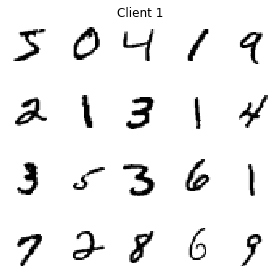

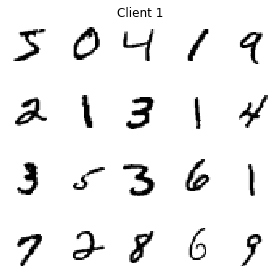

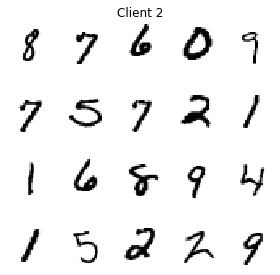

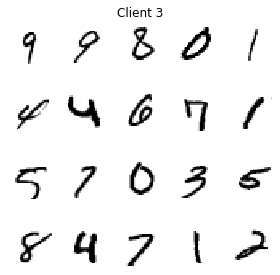

In [4]:
mnist_iid_train_dls[0].dataset.plot_samples(0, "Client 1")
mnist_iid_train_dls[0].dataset.plot_samples(1, "Client 1")
mnist_iid_train_dls[1].dataset.plot_samples(0, "Client 2")
mnist_iid_train_dls[2].dataset.plot_samples(0, "Client 3")

In [5]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet -> 
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

model_0= CNN()

In [6]:
def loss_classifier(predictions,labels):
    
    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")
    
    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, train_data, loss_f):
    """Compute the loss of `model` on `test_data`"""
    loss=0
    
    for idx,(features,labels) in enumerate(train_data):
        
        predictions= model(features)
        loss+=loss_f(predictions,labels)
    
    loss/=idx+1
    return loss


def accuracy_dataset(model,dataset):
    """Compute the accuracy of `model` on `test_data`"""
    
    correct=0
    
    for features,labels in iter(dataset):
        
        predictions= model(features)
        
        _,predicted=predictions.max(1,keepdim=True)
        
        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()
        
    accuracy = 100*correct/len(dataset.dataset)
        
    return accuracy


def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""
    
    total_loss=0
    
    for idx, (features,labels) in enumerate(train_data):
        
        optimizer.zero_grad()
        
        predictions= model(features)
        
        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss
        
        loss.backward()
        optimizer.step()
        
    return total_loss/(idx+1)



def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):
    
    model_0=deepcopy(model)
    
    for e in range(epochs):
        local_loss=train_step(model,model_0,mu,optimizer,train_data,loss_f)
        
    return float(local_loss.detach().numpy())


def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    
    tensor_1=list(model_1.parameters())
    tensor_2=list(model_2.parameters())
    
    norm=sum([torch.sum((tensor_1[i]-tensor_2[i])**2) 
        for i in range(len(tensor_1))])
    
    return norm


def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)
        
        
def FedAvg_agregation_process(model, clients_models_hist:list , weights:list):
    """Creates the new model of a given iteration with the models of the other
    clients"""
    
    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):
        
        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)
            
    return new_model



def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0, 
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the 
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularixation term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration
    
    returns :
        - `model`: the final global model 
    """
        
    loss_f=loss_classifier
    
    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)
    
    
    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach()) 
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy() 
        for tens_param in list(model.parameters())]]
    models_hist = []
    
    
    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')
    
    for i in range(n_iter):
        
        clients_params=[]
        clients_models=[]
        clients_losses=[]
        
        for k in range(K):
            
            local_model=deepcopy(model)
            local_optimizer=optim.SGD(local_model.parameters(),lr=lr)
            
            local_loss=local_learning(local_model,mu,local_optimizer,
                training_sets[k],epochs,loss_f)
            
            clients_losses.append(local_loss)
                
            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)    
            clients_models.append(deepcopy(local_model))
        
        
        #CREATE THE NEW GLOBAL MODEL
        model = FedAvg_agregation_process(deepcopy(model), clients_params, 
            weights=weights)
        models_hist.append(clients_models)
        
        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach()) 
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')
        

        server_hist.append([tens_param.detach().cpu().numpy() 
            for tens_param in list(model.parameters())])
        
        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay
            
    return model, loss_hist, acc_hist

In [7]:
"""RUN FEDAVG""" 
n_iter=10

model_f, loss_hist_FA_iid, acc_hist_FA_iid = FedProx( model_0, 
    mnist_iid_train_dls, n_iter, mnist_iid_test_dls, epochs =1, 
    lr =10**-1)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3005310694376626 Server Test Accuracy: 17.666666666666664
====> i: 1 Loss: 2.275256077448527 Server Test Accuracy: 35.666666666666664
====> i: 2 Loss: 2.2250470320383706 Server Test Accuracy: 56.33333333333333
====> i: 3 Loss: 2.035290241241455 Server Test Accuracy: 64.0
====> i: 4 Loss: 1.6802870432535806 Server Test Accuracy: 47.33333333333333
====> i: 5 Loss: 1.0283386707305908 Server Test Accuracy: 67.66666666666666
====> i: 6 Loss: 0.6468644936879475 Server Test Accuracy: 77.66666666666666
====> i: 7 Loss: 0.5616825620333353 Server Test Accuracy: 77.33333333333333
====> i: 8 Loss: 0.5173415839672089 Server Test Accuracy: 81.0
====> i: 9 Loss: 0.3061386744181315 Server Test Accuracy: 87.33333333333333
====> i: 10 Loss: 0.2781445781389872 Server Test Accuracy: 85.66666666666666


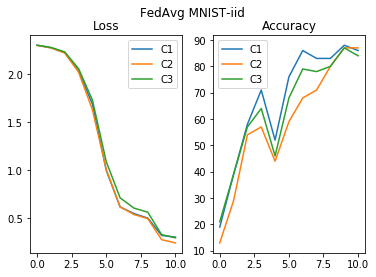

In [8]:
"""PLOT THE LOSS AND ACC HISTORY FOR THE DIFFERENT CLIENTS FOR FEDAVG"""

def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    plt.figure()
    
    plt.suptitle(title)

    plt.subplot(1,2,1)
    lines=plt.plot(loss_hist)
    plt.title("Loss")
    plt.legend(lines,["C1", "C2", "C3"])

    plt.subplot(1,2,2)
    lines=plt.plot(acc_hist )
    plt.title("Accuracy")
    plt.legend(lines, ["C1", "C2", "C3"])
    

plot_acc_loss("FedAvg MNIST-iid", loss_hist_FA_iid, acc_hist_FA_iid)

In [9]:
"""RUN FEDPROx, mu=1""" 
n_iter=10

model_f, loss_hist_FP_iid, acc_hist_FP_iid = FedProx( model_0, 
    mnist_iid_train_dls, n_iter, mnist_iid_test_dls, 
    epochs =1, lr =0.1, mu =1.)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3005310694376626 Server Test Accuracy: 17.666666666666664
====> i: 1 Loss: 2.2830518881479898 Server Test Accuracy: 33.666666666666664
====> i: 2 Loss: 2.2552429040273028 Server Test Accuracy: 22.0
====> i: 3 Loss: 2.193825880686442 Server Test Accuracy: 50.666666666666664
====> i: 4 Loss: 2.009840250015259 Server Test Accuracy: 52.666666666666664
====> i: 5 Loss: 1.5914920568466184 Server Test Accuracy: 55.0
====> i: 6 Loss: 1.1029500563939412 Server Test Accuracy: 71.0
====> i: 7 Loss: 0.8971444567044575 Server Test Accuracy: 74.0
====> i: 8 Loss: 0.8154087861378987 Server Test Accuracy: 69.66666666666666
====> i: 9 Loss: 0.5335853099822998 Server Test Accuracy: 81.0
====> i: 10 Loss: 0.4730209112167358 Server Test Accuracy: 79.66666666666666


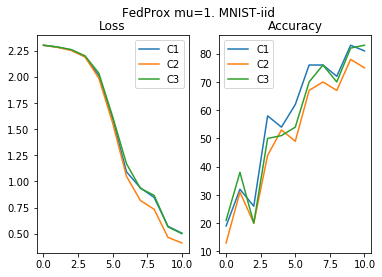

In [10]:
plot_acc_loss("FedProx mu=1. MNIST-iid", loss_hist_FP_iid, acc_hist_FP_iid)

## 2. MNIST non-iid

In [11]:
C= {
     'n_samples_train': 200,
     'font':'InconsolataN',
     'tilt': [0, 45, 90],
     'std_tilt': 10, #std on the tilt,
     'seed':0
     }
C['n_samples']= int(1.5 * C['n_samples_train']) #20% more for the testing set

C1 =deepcopy(C)
C1['numbers'] = [1, 2, 3]

C2=deepcopy(C)
C2['numbers'] = [4, 5, 6]

C3=deepcopy(C)
C3['numbers']= [7, 8, 9]

clients = [C1, C2, C3]

In [12]:
from create_MNIST_datasets import get_MNIST_niid
custom_mnist_train, custom_mnist_test = get_MNIST_niid(
    clients, batch_size =10)

0 %
3 %
7 %
10 %
13 %
17 %
20 %
23 %
27 %
30 %
33 %
37 %
40 %
43 %
47 %
50 %
53 %
57 %
60 %
63 %
67 %
70 %
73 %
77 %
80 %
83 %
87 %
90 %
93 %
97 %
0 %
3 %
7 %
10 %
13 %
17 %
20 %
23 %
27 %
30 %
33 %
37 %
40 %
43 %
47 %
50 %
53 %
57 %
60 %
63 %
67 %
70 %
73 %
77 %
80 %
83 %
87 %
90 %
93 %
97 %
0 %
3 %
7 %
10 %
13 %
17 %
20 %
23 %
27 %
30 %
33 %
37 %
40 %
43 %
47 %
50 %
53 %
57 %
60 %
63 %
67 %
70 %
73 %
77 %
80 %
83 %
87 %
90 %
93 %
97 %


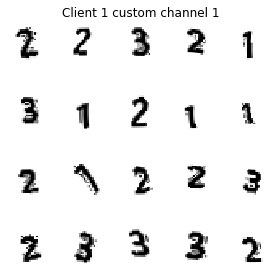

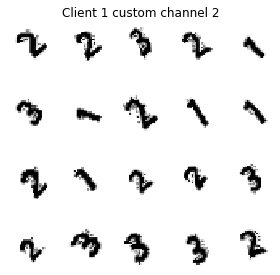

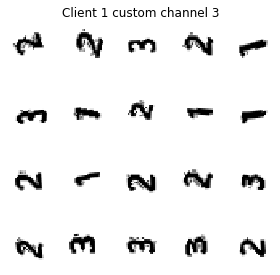

In [13]:
custom_mnist_train[0].dataset.plot_samples(0, "Client 1 custom channel 1")
custom_mnist_train[0].dataset.plot_samples(1, "Client 1 custom channel 2")
custom_mnist_train[0].dataset.plot_samples(2, "Client 1 custom channel 3")

In [14]:
n_iter=15

model_f, loss_hist_FA_niid, acc_hist_FA_niid = FedProx( model_0, custom_mnist_train, 
    n_iter, custom_mnist_test, epochs=1, lr=0.1)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3026341597239175 Server Test Accuracy: 15.0
====> i: 1 Loss: 2.246858199437459 Server Test Accuracy: 7.0
====> i: 2 Loss: 2.1937777201334634 Server Test Accuracy: 10.0
====> i: 3 Loss: 2.1537030537923174 Server Test Accuracy: 20.0
====> i: 4 Loss: 2.0848255157470703 Server Test Accuracy: 26.666666666666664
====> i: 5 Loss: 1.992700417836507 Server Test Accuracy: 44.0
====> i: 6 Loss: 1.7524708906809487 Server Test Accuracy: 37.33333333333333
====> i: 7 Loss: 1.5366146167119343 Server Test Accuracy: 60.66666666666666
====> i: 8 Loss: 1.3610893090565999 Server Test Accuracy: 57.99999999999999
====> i: 9 Loss: 1.1237127780914307 Server Test Accuracy: 61.33333333333333
====> i: 10 Loss: 0.9128623008728027 Server Test Accuracy: 62.0
====> i: 11 Loss: 0.8876070181528726 Server Test Accuracy: 70.0
====> i: 12 Loss: 0.7139588594436646 Server Test Accuracy: 74.33333333333333
====> i: 13 Loss: 0.683

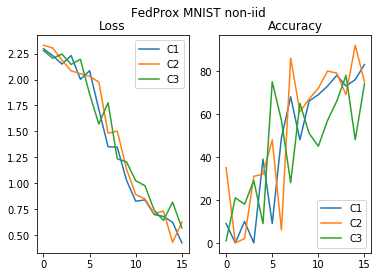

In [15]:
plot_acc_loss("FedProx MNIST non-iid", loss_hist_FA_niid, acc_hist_FA_niid)

In [16]:
n_iter=15

model_f, loss_hist_FP_niid, acc_hist_FP_niid = FedProx( model_0, custom_mnist_train, 
    n_iter, custom_mnist_test, epochs=1, lr=0.1, mu=.1)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3026340802510576 Server Test Accuracy: 15.0
====> i: 1 Loss: 2.265202522277832 Server Test Accuracy: 15.0
====> i: 2 Loss: 2.2309112548828125 Server Test Accuracy: 13.333333333333332
====> i: 3 Loss: 2.190657059351603 Server Test Accuracy: 13.999999999999998
====> i: 4 Loss: 2.147770643234253 Server Test Accuracy: 20.0
====> i: 5 Loss: 2.0802175203959146 Server Test Accuracy: 24.0
====> i: 6 Loss: 1.8976590236028035 Server Test Accuracy: 32.666666666666664
====> i: 7 Loss: 1.8608551422754922 Server Test Accuracy: 43.666666666666664
====> i: 8 Loss: 1.5305087566375732 Server Test Accuracy: 46.666666666666664
====> i: 9 Loss: 1.3251219590504963 Server Test Accuracy: 59.33333333333333
====> i: 10 Loss: 1.252299189567566 Server Test Accuracy: 59.33333333333333
====> i: 11 Loss: 0.9710155924161274 Server Test Accuracy: 60.666666666666664
====> i: 12 Loss: 1.0140491326649983 Server Test Accuracy

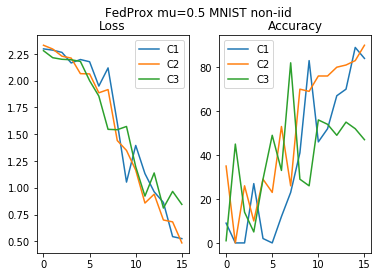

In [17]:
plot_acc_loss("FedProx mu=0.5 MNIST non-iid", loss_hist_FP_niid, acc_hist_FP_niid)